# Gradient Boosting Regression on California Housing Dataset
This notebook demonstrates use of scikit-learn’s `GradientBoostingRegressor` for continuous prediction.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sns.set_theme()

## Data Loading & Exploration
Load the California Housing dataset and inspect its dimensions and summary statistics.

In [3]:
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='MedHouseValue')
print(f"Feature matrix: {X.shape}")

Feature matrix: (20640, 8)


In [4]:
display(X.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [5]:
print(y.describe())

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseValue, dtype: float64


## Exploratory Visualization
Plot **Median Income** vs **Median House Value** to inspect relationships.

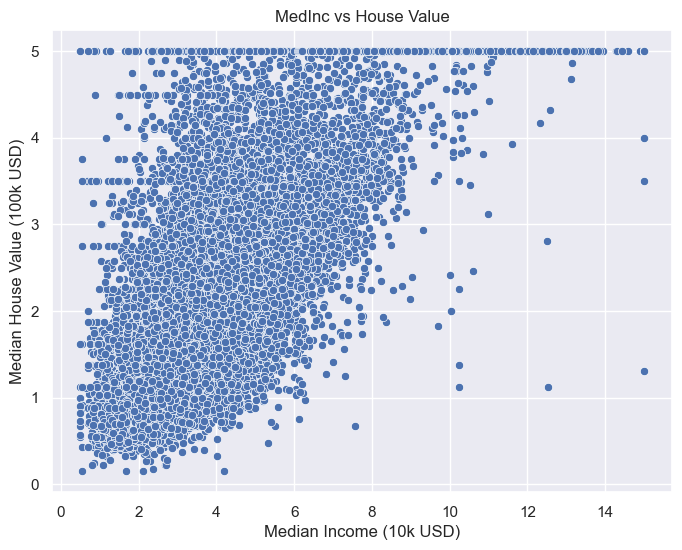

In [6]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X['MedInc'], y=y)
plt.xlabel('Median Income (10k USD)')
plt.ylabel('Median House Value (100k USD)')
plt.title('MedInc vs House Value')
plt.show()

## Train/Test Split
Split into 80% train and 20% test sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 16512, Test samples: 4128


Gradient boosting works by sequentially training new models on the old model's prediction errors. Iteratively, we get a better and better approximation of the true function.

Given features ```X``` and regression values ```y```, we train a regression tree ```tree_reg1``` on this data and then ```tree_reg1``` predicts a vector $\hat{y}_1$ of real values. Then,

$$
y - \hat{y}_1 = error_1
$$

Next fit another regression tree, say ```tree_reg2```, with features ```X``` and labels $y_2 = y - \hat{y}_1$. Then, ```tree_reg2``` predict a vector $\hat{y}_2$, with 

$$
error_1 = y_2 = \hat{y}_2 + error_2
$$

Thus, 

$$
y = \hat{y}_1 + error_1 = \hat{y}_1 + \hat{y}_2 + error_2, 
$$
where $error_1 > error_2$. 

As we continue iteratively, the error gets smaller and smaller.

## Training Default Gradient Boosting Regressor
Use default settings (`n_estimators=100`, `learning_rate=0.1`, `max_depth=3`).

In [8]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"R²:  {r2_score(y_test, y_pred):.3f}")

MSE: 0.294
MAE: 0.372
R²:  0.776


## Feature Importances
Plot the importance of each feature.

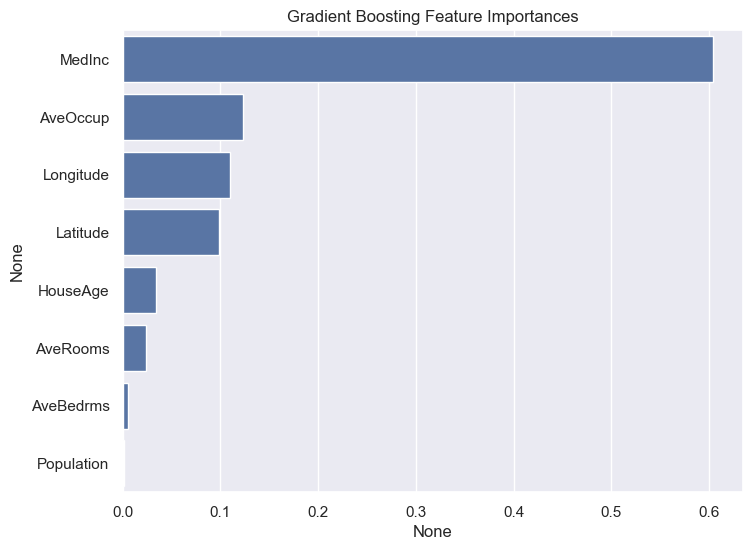

In [9]:
fi = pd.Series(gbr.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=fi, y=fi.index)
plt.title('Gradient Boosting Feature Importances')
plt.show()

## Predicted vs. Actual & Residual Distribution
Scatter plot and histogram of residuals.

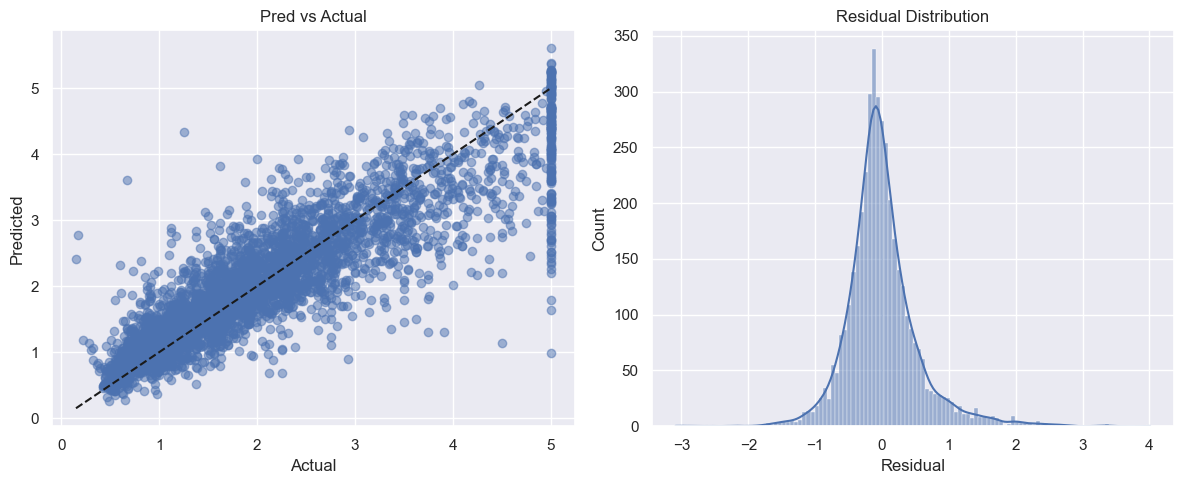

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()],'k--')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Pred vs Actual')
plt.subplot(1,2,2)
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel('Residual'); plt.title('Residual Distribution')
plt.tight_layout(); plt.show()

## Validation Curve: learning_rate
Plot training and CV MSE vs. learning rate.

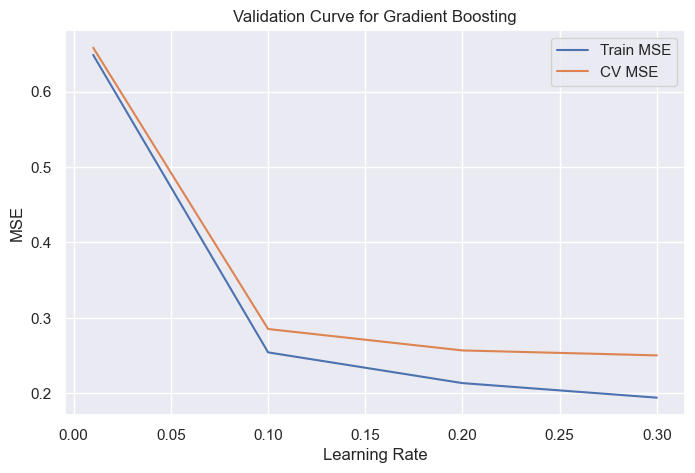

In [11]:
param_range = [0.01, 0.1, 0.2, 0.3]
train_scores, test_scores = validation_curve(
    GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    X_train, y_train, param_name='learning_rate', param_range=param_range,
    cv=5, scoring='neg_mean_squared_error'
)
train_mse = -train_scores.mean(axis=1)
test_mse = -test_scores.mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(param_range, train_mse, label='Train MSE')
plt.plot(param_range, test_mse, label='CV MSE')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.title('Validation Curve for Gradient Boosting')
plt.legend(); plt.grid(True); plt.show()

0.1 is about optimal for the learning rate.

## Effect of `n_estimators` & `max_depth` on Gradient Boosting Performance

We’ll use scikit-learn’s `validation_curve` to see how varying the number of trees (`n_estimators`) and the maximum depth of each tree (`max_depth`) affects our model’s test‐set MSE.  We keep the other hyperparameters at their cross-validated optimum (e.g.`learning_rate=0.1`).